# Rectangular Integration of RNA+ADT

In this tutorial, we demonstrate how to integrate a dataset consisting of RNA and ADT data. We will also walk through the inference process and the some of the outputs generated by MIDAS.

## Step 1: Downloading the Demo Data and Model

In [ ]:
from scmidas.data import download_data, download_models
download_data('wnn_full_8batch_mtx', './')
download_models('wnn_full_8batch_mtx', './')

## Step 2: Setting Up the Environment

Before we begin, ensure that the required environment is set up. This includes importing the necessary packages and dependencies.

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from scmidas.config import load_config
from scmidas.model import MIDAS
import lightning as L
from lightning import seed_everything

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))
seed_everything(42)

Seed set to 42


42

## Step 3: Configuring the Model

We use default configuration here.

In [3]:
configs = load_config() # refer to Tutotrials/Advanced/Development Instructions for details
configs['num_workers'] = 2

INFO:root:The model is initialized with the default configurations.


In [4]:
task = 'wnn_full_8batch_mtx'
model = MIDAS.configure_data_from_dir(configs, './dataset/'+task+'/data')

INFO:root:Input data: 
         #CELL  #ADT  #RNA  #VALID_ADT  #VALID_RNA
BATCH 0   6378   224  3617         224        3617
BATCH 1   5899   224  3617         224        3617
BATCH 2   4628   224  3617         224        3617
BATCH 3   5285   224  3617         224        3617
BATCH 4   6952   224  3617         224        3617
BATCH 5   6060   224  3617         224        3617
BATCH 6   8854   224  3617         224        3617
BATCH 7   8908   224  3617         224        3617


## Step 4: Training the Model

Instead of training the model from scratch, we will utilize a pre-trained model for this demonstration.

In [ ]:
model.load_checkpoint(f'./saved_models/{task}.pt')

In [ ]:
# Train from start:
# trainer = L.Trainer(max_epochs=1500)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
# trainer.fit(model=model)

## Step 5: Prediction

In this step, we explore the various outputs generated by MIDAS.

In [10]:
# Load labels.
label = []
batch_id = []
for i in [f'p{j}_0' for j in range(1,9)]:
    label.append(pd.read_csv('./dataset/'+task+'/label/%s.csv'%i, index_col=0).values.flatten())
    batch_id.append([i] * len(label[-1]))
labels = np.concatenate(label)
batch_ids = np.concatenate(batch_id)

### Joint Embeddings

In [ ]:
# Load joint latent embeddings.
# If you prefer to save the joint latent embeddings to disk, 
# you can set `save_dir` in the scmidas.model.MIDAS.predict() method 
joint_embeddings = model.predict()

The joint embeddings consist of two components: biological information $c$ and technical information $u$.

To analyze them, we split the embeddings and visualize them separately.

INFO:root:Predicting ...
INFO:root:Processing batch 0: ['adt', 'rna']
100%|██████████| 25/25 [00:22<00:00,  1.12it/s]
INFO:root:Processing batch 1: ['adt', 'rna']
100%|██████████| 24/24 [00:21<00:00,  1.10it/s]
INFO:root:Processing batch 2: ['adt', 'rna']
100%|██████████| 19/19 [00:16<00:00,  1.14it/s]
INFO:root:Processing batch 3: ['adt', 'rna']
100%|██████████| 21/21 [00:18<00:00,  1.13it/s]
INFO:root:Processing batch 4: ['adt', 'rna']
100%|██████████| 28/28 [00:24<00:00,  1.13it/s]
INFO:root:Processing batch 5: ['adt', 'rna']
100%|██████████| 24/24 [00:21<00:00,  1.11it/s]
INFO:root:Processing batch 6: ['adt', 'rna']
100%|██████████| 35/35 [00:37<00:00,  1.07s/it]
INFO:root:Processing batch 7: ['adt', 'rna']
100%|██████████| 35/35 [00:41<00:00,  1.18s/it]
... storing 'batch' as categorical
... storing 'label' as categorical


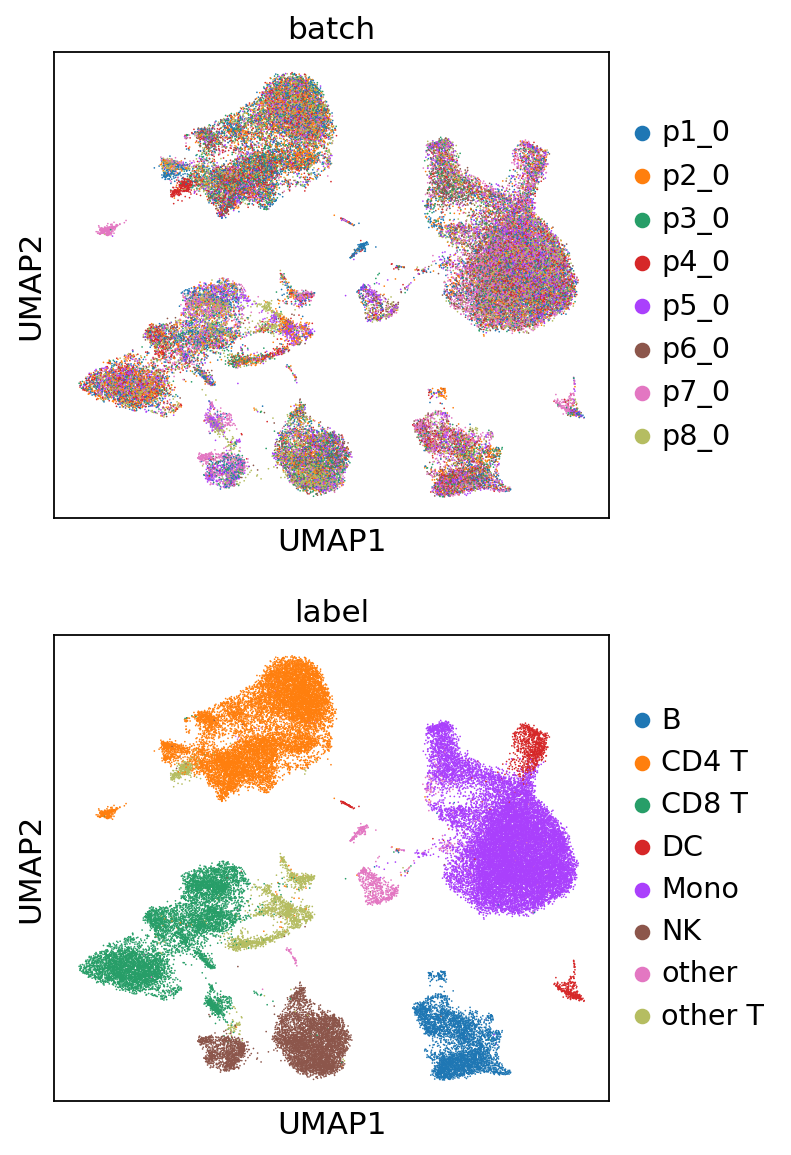

... storing 'batch' as categorical
... storing 'label' as categorical


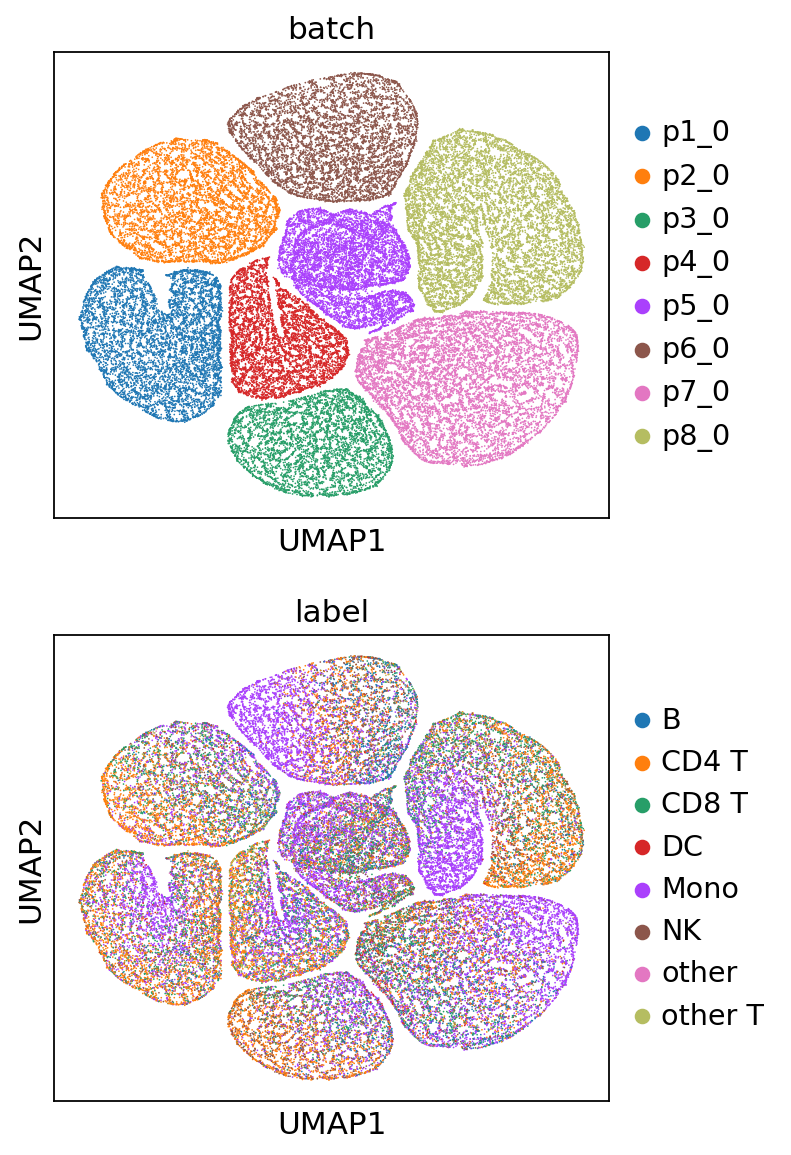

In [ ]:
adata_bio = sc.AnnData(joint_embeddings['z']['joint'][:, :model.dim_c])
adata_tech = sc.AnnData(joint_embeddings['z']['joint'][:, model.dim_c:])

adata_bio.obs['batch'] = batch_ids
adata_bio.obs['label'] = labels
adata_tech.obs['batch'] = batch_ids
adata_tech.obs['label'] = labels

sc.pp.subsample(adata_bio, fraction=1) # shuffle
sc.pp.subsample(adata_tech, fraction=1) # shuffle
for adata in [adata_bio, adata_tech]:
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['batch', 'label'], ncols=1)

### Modality Embeddings

MIDAS can generate embeddings for each modality. Here, we check the alignment among modalities by visualizing them with UMAP.

In [ ]:
mod_embeddings = model.predict(mod_latent=True, group_by='batch')

batch_names = [f'p{j}_0' for j in range(1,9)]
adata_list = []
for i in range(model.dims_s['joint']):
    for m in model.mods+['joint']:
        if m in mod_embeddings[i]['z']:
            adata = sc.AnnData(mod_embeddings[i]['z'][m][:, :model.dim_c])
            adata.obs['batch'] = batch_names[i]
            adata.obs['modality'] = m
            adata.obs['label'] = label[i]
            adata_list.append(adata)
adata_mod_concat = sc.concat(adata_list)
for i in adata_mod_concat.obs:
    adata_mod_concat.obs[i] = adata_mod_concat.obs[i].astype('category')
sc.pp.neighbors(adata_mod_concat)
sc.pp.subsample(adata_mod_concat, fraction=1) # shuffle
sc.tl.umap(adata_mod_concat)

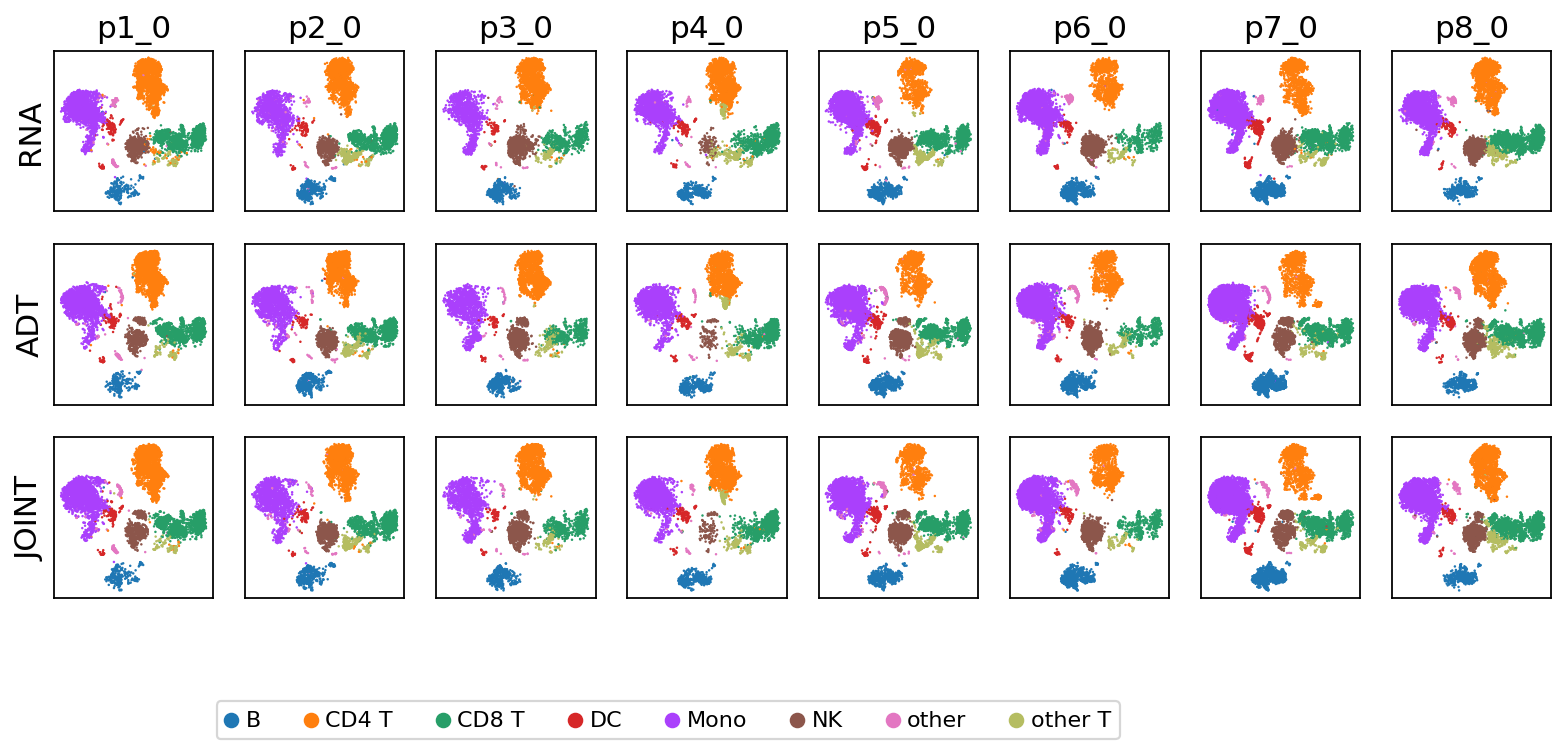

In [24]:
# setup figure
nrows = len(model.mods) + 1
ncols = model.dims_s['joint']
point_size = 5

fig, ax = plt.subplots(nrows, ncols, figsize=[1.5 * ncols, 1.5 * nrows])

# set up the name of modalities and batch
mod_names = model.mods + ['joint']

# iteratively scatter the data
for i, mod in enumerate(mod_names):
    for b in range(model.dims_s['joint']):
        # filter data
        adata = adata_mod_concat[
            (adata_mod_concat.obs['modality'] == mod) & 
            (adata_mod_concat.obs['batch'] == batch_names[b])
        ].copy()
        if len(adata):
            sc.pl.umap(adata, color='label', show=False, ax=ax[i, b], s=point_size)
            ax[i, b].get_legend().set_visible(False)
            handles, labels_ = ax[i, b].get_legend_handles_labels()
        ax[i, b].set_xticks([])
        ax[i, b].set_yticks([])
        ax[i, b].set_xlabel('')
        if b==0:
            ax[i, b].set_ylabel(mod.upper())
        else:
            ax[i, b].set_ylabel('')
        if i==0:
            ax[i, b].set_title(batch_names[b])
        else:
            ax[i, b].set_title('')
# create global legend
fig.legend(handles, labels_, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=len(labels_), fontsize=10)

# adjust the figure
# plt.tight_layout(rect=[0.1, 0.05, 1, 1])
plt.show()

### Batch-corrected Counts

By using the `standard noise`, we can generate the batch-corrected data. To validate the batch effect in the predicted multi-modalities counts, we use PCA+WNN to gain the joint embeddings for them. First of all, we load the batch-corrected counts.

In [ ]:
batch_corrected_counts = model.predict(batch_correct=True)

To reduce computation time, we will randomly select a subset of samples for the analysis.

In [ ]:
select = np.random.choice(list(range(len(batch_corrected_counts['x_bc']['rna']))), 2000, replace=False)
select

Save the data to CSV files for later use in R.

In [8]:
pd.DataFrame(batch_corrected_counts['x_bc']['rna'][select]).T.to_csv('temp_rna.csv', index=True)
pd.DataFrame(batch_corrected_counts['x_bc']['adt'][select]).T.to_csv('temp_adt.csv', index=True)

Set up the R environment.

In [ ]:
import os
os.environ["R_HOME"] = "/usr/lib/R"
os.environ["R_LIBS_USER"] = "/usr/lib/R/lib"
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
importr('Seurat')
importr('SeuratDisk')
importr('dplyr')
importr('Signac')

PCA+WNN

In [ ]:
ro.r('''
rna <- as.matrix(read.csv('./temp_rna.csv', header=TRUE, row.names=1))
adt <- as.matrix(read.csv('./temp_adt.csv', header=TRUE, row.names=1))
obj <- CreateSeuratObject(counts = rna, assay = "rna")
obj[["adt"]] <- CreateAssayObject(counts = adt)
obj <- subset(obj, subset = nCount_rna > 0 & nCount_adt > 0)
print(obj)
DefaultAssay(obj) <- 'rna'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj) %>%
        # FindVariableFeatures(nfeatures = 2000) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_rna", verbose = F)
print('finish rna')
DefaultAssay(obj) <- 'adt'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj, normalization.method = "CLR", margin = 2) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_adt", verbose = F)
print('finish adt')
print('WNN ...')
obj <- FindMultiModalNeighbors(obj, list("pca_rna", "pca_adt"), list(1:32, 1:32))
obj <- RunUMAP(obj, nn.name = "weighted.nn", reduction.name = "umap")
''')

... storing 'label' as categorical
... storing 'batch' as categorical


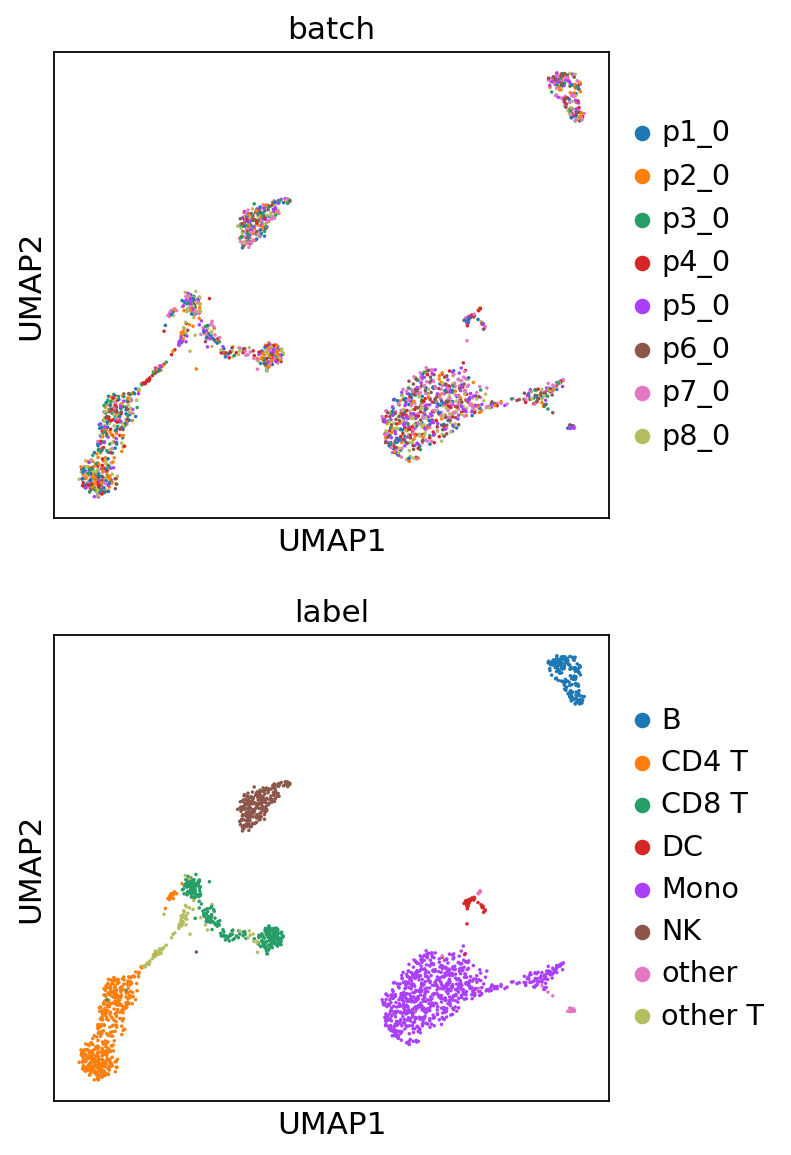

In [13]:
# Create an AnnData object with 'X' not being used, so we initialize it with all zeros
adata = sc.AnnData(np.zeros([2000, 1]))
adata.obs['label'] = labels[select]
adata.obs['batch'] = batch_ids[select]
f = ro.r('''DimPlot(obj, reduction='umap')''')
adata.obsm['umap'] = pd.DataFrame(f[0]).iloc[:2].T.values
# shuffle
sc.pp.subsample(adata, fraction=1)
sc.pl.umap(adata, color=['batch', 'label'], ncols=1, size=10)

Similarly, we load the raw counts and visualize the UMAP using the same procedure.

In [ ]:
inputs = model.predict('./predict/'+task, input=True, group_by='modality')

In [15]:
pd.DataFrame(inputs['x']['rna'][select]).T.to_csv('temp_rna.csv', index=True)
pd.DataFrame(inputs['x']['adt'][select]).T.to_csv('temp_adt.csv', index=True)

In [ ]:
ro.r('''
rna <-  read.csv('./temp_rna.csv', header=TRUE, row.names=1)
adt <- read.csv('./temp_adt.csv', header=TRUE, row.names=1)
obj <- CreateSeuratObject(counts = rna, assay = "rna")
obj[["adt"]] <- CreateAssayObject(counts = adt)
obj <- subset(obj, subset = nCount_rna > 0 & nCount_adt > 0)
print(obj)
DefaultAssay(obj) <- 'rna'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj) %>%
        # FindVariableFeatures(nfeatures = 2000) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_rna", verbose = F)
print('finish rna')
DefaultAssay(obj) <- 'adt'
VariableFeatures(obj) <- rownames(obj)
obj <-  NormalizeData(obj, normalization.method = "CLR", margin = 2) %>%
        ScaleData() %>%
        RunPCA(reduction.name = "pca_adt", verbose = F)
print('finish adt')
print('WNN ...')
obj <- FindMultiModalNeighbors(obj, list("pca_rna", "pca_adt"), list(1:32, 1:32))
obj <- RunUMAP(obj, nn.name = "weighted.nn", reduction.name = "umap")
''')

... storing 'label' as categorical
... storing 'batch' as categorical


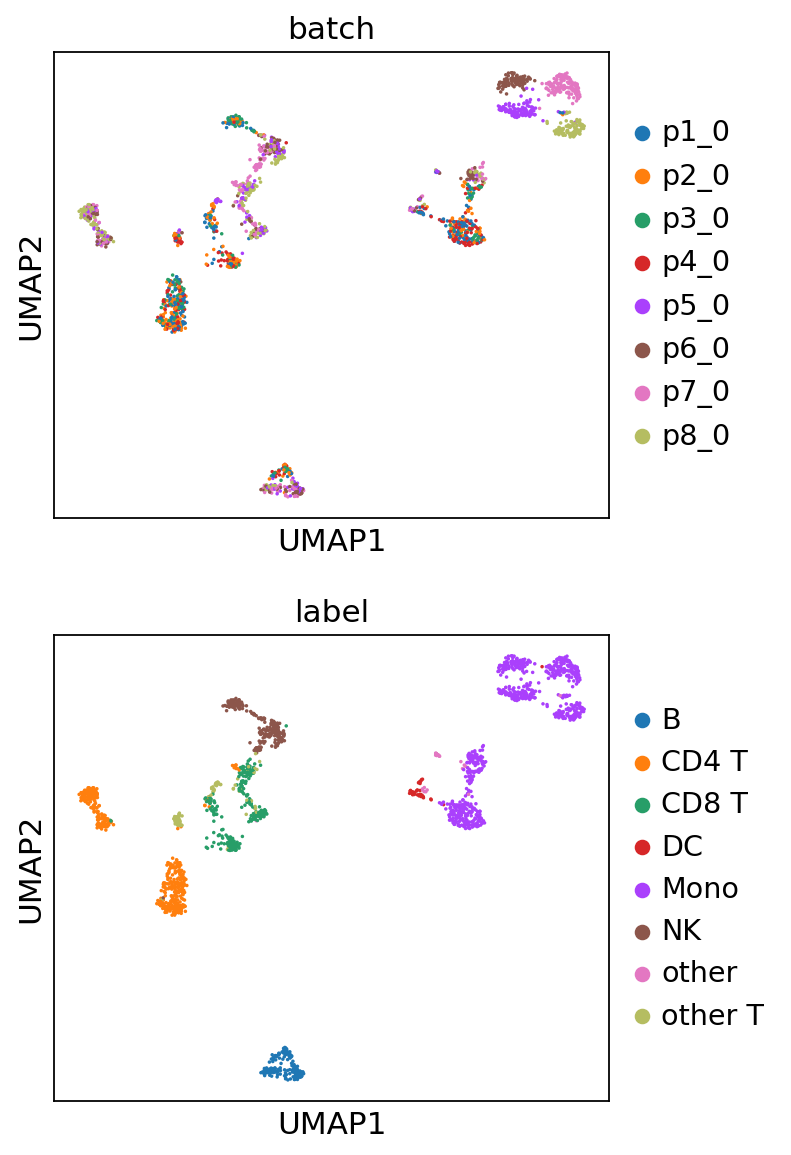

In [17]:
adata = sc.AnnData(np.zeros([2000, 1]))
adata.obs['label'] = labels[select]
adata.obs['batch'] = batch_ids[select]
f = ro.r('''
     DimPlot(obj, reduction='umap')
     ''')
adata.obsm['umap'] = pd.DataFrame(f[0]).iloc[:2].T.values
# shuffle
sc.pp.subsample(adata, fraction=1)
sc.pl.umap(adata, color=['batch', 'label'], ncols=1, size=10)

For the raw data, prominent batch effects are observed, where clusters of cells are segregated based on batches.
For the MIDAS batch-corrected counts, these batch effects are effectively removed, leading to well-integrated clusters.